Importing Library files

In [ ]:
import torch
import torchvision.datasets as datasets
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import gzip


Define a Function to print our final output images according to our model and the chnages we're gonna do

In [ ]:
def plot_generated_images(data_loader, model, device,
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images,
                             sharex=True, sharey=True, figsize=figsize)

    for batch_idx, (features, _) in enumerate(data_loader):

        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]

        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')

Device Settings and Hyperparameters

In [ ]:
#Device Settings
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

#Hyperparameters
lr = 3e-4
batch_size = 64
beta = 2
epochs = 15
z_dim = 10
n_images=15
figsize=(20, 2.5)

cuda


Code Implementation of Disentangled Variational Autoencoder VAE

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


#Defining Disentangled Variational Autoencoder
class VariationalAutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = (3,3), stride = (1,1), padding = 1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = (3,3), stride = (2,2), padding = 1)
    self.conv3 = nn.Conv2d(64, 64, kernel_size = (3,3), stride = (2,2), padding = 1)
    self.conv4 = nn.Conv2d(64, 64, kernel_size = (3,3), stride = (1,1), padding = 1)
    self.lrelu = nn.LeakyReLU(0.01)
    self.flat = nn.Flatten()
    self.zmean = nn.Linear(3136, z_dim)
    self.zvar = nn.Linear(3136, z_dim)
    self.li = nn.Linear(z_dim, 3136)
    self.res = Reshape(-1, 64, 7, 7)
    self.trim = Trim()
    self.tanh = nn.Tanh()
    self.tconv1 = nn.ConvTranspose2d(64, 64, stride = (1,1), kernel_size=(3,3), padding = 1)
    self.tconv2 = nn.ConvTranspose2d(64, 64, stride = (2,2), kernel_size=(3,3), padding = 1)
    self.tconv3 = nn.ConvTranspose2d(64, 32, stride = (2,2), kernel_size=(3,3), padding = 0)
    self.tconv4 = nn.ConvTranspose2d(32, 1, stride = (1,1), kernel_size=(3,3), padding = 0)

  #to encode the data using bottleneck method dividing it into 2D Latent Space
  def encode(self, x):
    x = self.conv1(x)
    x = self.lrelu(x)
    x = self.conv2(x)
    x = self.lrelu(x)
    x = self.conv3(x)
    x = self.lrelu(x)
    x = self.conv4(x)
    x = self.flat(x)
    zmean, zvar = self.zmean(x), self.zvar(x)
    # x = reparameterize(zmean, zvar)
    return zmean, zvar

  #to overcome problem of backpropogation
  def reparameterize(self, z_m, z_v):
    epsilon = torch.randn_like(z_m).to(z_m.get_device())
    encoded = z_m + epsilon*torch.exp(z_v/2.)
    return encoded

  #decode the latent vector
  def decode(self, x):
    x = self.li(x)
    # y = x
    # torch.reshape(x, (-1, 64, 7, 7))
    # x.view(-1, 64, 7, 7)
    # y.to(x.get_device())
    # x = y
    x = self.res(x)
    x = self.tconv1(x)
    x = self.lrelu(x)
    x = self.tconv2(x)
    x = self.lrelu(x)
    x = self.tconv3(x)
    x = self.lrelu(x)
    x = self.tconv4(x)
    x = self.trim(x)
    x = self.tanh(x)
    return x

  def forward(self,x):
    z_mean, z_var = self.encode(x)
    encoded = self.reparameterize(z_mean, z_var)
    decode = self.decode(encoded)
    return encoded, z_mean, z_var, decode


#training Disentabgled VAE

def train_vae(Num_epochs, optimiser, model, device, train_loader, log_interval = 100, loss_fn=None, save_model = None, reconstruction_weight = 0.4):
  log_dict = {
      'train combined loss per batch': [],
      'train combined loss per epoch': [],
      'train reconstruction loss per batch': [],
      'train kl loss per batch': []
  }
  if loss_fn is None:
    loss_fn = F.mse_loss

  start_time = time.time()
  for epoch in range(Num_epochs):
    model.train()
    for batch_index, (features, _) in enumerate(train_loader):
      features = features.to(device)

      encoded, z_mean, z_var, decoded = model(features)

      # print(features.size())
      # print("abe print krr mujhe")
      # print(decoded.size())


      #KL Divergence formula
      kl_div = -0.5 * torch.sum(1 + z_var - z_mean**2 - torch.exp(z_var), axis = 1)
      batchsize = kl_div.size(0)
      kl_div = kl_div.mean()


      #Expectationh Value
      pixelwise = loss_fn(decoded, features, reduction = 'none')
      pixelwise = pixelwise.view(batchsize, -1).sum(axis = 1)
      pixelwise = pixelwise.mean()

      #Loss function calculation using beta value, KL Divergence and Expectation values
      loss = reconstruction_weight*pixelwise + beta*kl_div

      optimiser.zero_grad()

      loss.backward()

      optimiser.step()

      log_dict['train combined loss per batch'].append(loss.item())
      log_dict['train reconstruction loss per batch'].append(pixelwise.item())
      log_dict['train kl loss per batch'].append(kl_div.item())

      if not batch_index % log_interval:
        print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, Num_epochs, batch_index,
                          len(train_loader), loss))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

  print('Total training time: %.2f min' % ((time.time() - start_time)/60))
  if save_model is not None:
    torch.save(model.state_dict(),save_model)

  return log_dict


Importing Dataset

We've selected FashionMNIST

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
fdataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
trainloader = DataLoader(fdataset, batch_size=64, shuffle=True)

images, labels = next(iter(trainloader))
print(f"{images.shape=} {labels.shape=}")

100%|██████████| 26421880/26421880 [00:03<00:00, 8539970.63it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 140140.60it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2661326.71it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21570706.29it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

images.shape=torch.Size([64, 1, 28, 28]) labels.shape=torch.Size([64])


## **Traning our model**

In [ ]:
#initialising model
model = VariationalAutoEncoder()
model.to(DEVICE)

#selecting adam optimiser
optimiser = optim.Adam(model.parameters(), lr=lr)


start the process of training our model on the selected dataset

In [ ]:
log_dict = train_vae(Num_epochs = epochs, optimiser = optimiser, model = model, device = DEVICE,train_loader = trainloader, log_interval = 50, loss_fn = F.mse_loss, reconstruction_weight = 8)

Epoch: 001/015 | Batch 0000/0938 | Loss: 3832.3137
Epoch: 001/015 | Batch 0050/0938 | Loss: 2016.1681
Epoch: 001/015 | Batch 0100/0938 | Loss: 940.7300
Epoch: 001/015 | Batch 0150/0938 | Loss: 731.5504
Epoch: 001/015 | Batch 0200/0938 | Loss: 668.2231
Epoch: 001/015 | Batch 0250/0938 | Loss: 608.1366
Epoch: 001/015 | Batch 0300/0938 | Loss: 630.6032
Epoch: 001/015 | Batch 0350/0938 | Loss: 593.7855
Epoch: 001/015 | Batch 0400/0938 | Loss: 546.4828
Epoch: 001/015 | Batch 0450/0938 | Loss: 548.8585
Epoch: 001/015 | Batch 0500/0938 | Loss: 473.8788
Epoch: 001/015 | Batch 0550/0938 | Loss: 530.3403
Epoch: 001/015 | Batch 0600/0938 | Loss: 480.0841
Epoch: 001/015 | Batch 0650/0938 | Loss: 454.4465
Epoch: 001/015 | Batch 0700/0938 | Loss: 493.0826
Epoch: 001/015 | Batch 0750/0938 | Loss: 489.4584
Epoch: 001/015 | Batch 0800/0938 | Loss: 435.3893
Epoch: 001/015 | Batch 0850/0938 | Loss: 526.6686
Epoch: 001/015 | Batch 0900/0938 | Loss: 535.2482
Time elapsed: 0.46 min
Epoch: 002/015 | Batch 00

## **Evaluation**

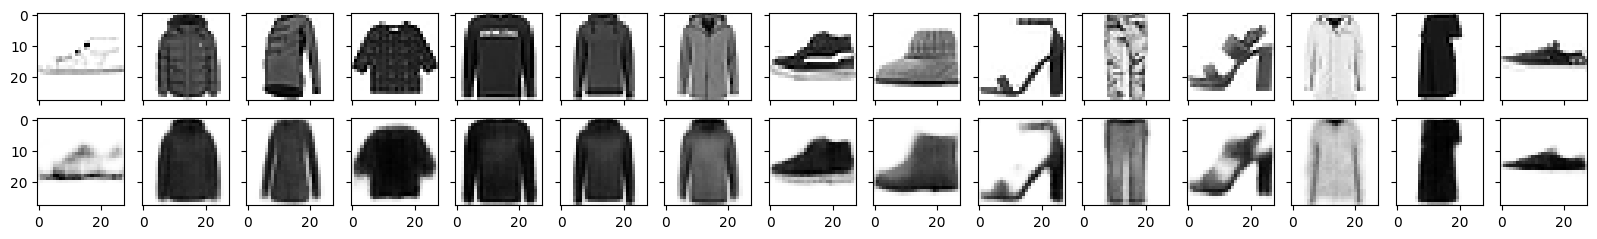

In [ ]:
#verifying the encoded and decoded images by our model to original one
plot_generated_images(data_loader=trainloader, model=model, device=DEVICE, modeltype='VAE')

Changing the latent vector and observing the changes in final image

Disturbing the particular neuron leads to some specific change, rest of the specification of image will remain untouched

In [ ]:
for batch_idx, (features, _) in enumerate(trainloader):

    features = features.to(DEVICE)

    color_channels = features.shape[1]
    image_height = features.shape[2]
    image_width = features.shape[3]

    en, z_mean, z_log_var, de = model(features)[:n_images]
    # with torch.no_grad():
    #         encode, z_mean, z_log_var, decoded = model(features)[:n_images]

    orig_images = features[:n_images]
    break
encode = en[:15]
decoded = de[:15]
encode.to(DEVICE)
disturb = torch.zeros((15,10)).to(encode.get_device())
disturb[:, 8] = 3
disturb
# print(encode.get_device())
# print(disturb.get_device())
# print(en.get_device())
encoded = encode + disturb
decoded_images = model.decode(encoded)

# print(encode)
# print(encoded)


Printing the three variations we did in the above code

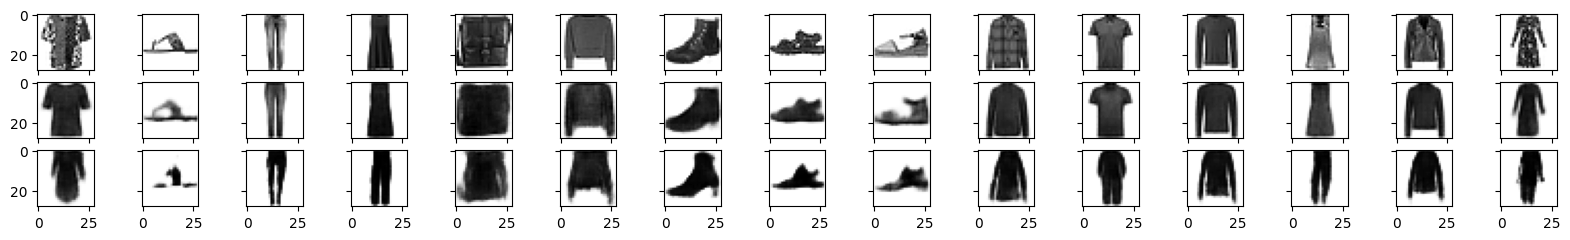

In [ ]:
unnormalizer = None
fig, axes = plt.subplots(nrows=3, ncols=n_images,
                          sharex=True, sharey=True, figsize=figsize)

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        if unnormalizer is not None:
            curr_img = unnormalizer(curr_img)

        if color_channels > 1:
            curr_img = np.transpose(curr_img, (1, 2, 0))
            ax[i].imshow(curr_img)
        else:
            ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')

In [ ]:
encode.max(), encode.min(), encode.mean()

(tensor(3.0056, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-3.1753, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.0389, device='cuda:0', grad_fn=<MeanBackward0>))

In [ ]:
# e = torch.rand(1, 10).to(DEVICE) * torch.tensor([2.5332+2.8509]).to(DEVICE) - torch.tensor([2.8509]).to(DEVICE)
# e = torch.rand(1, 10) * torch.tensor([2.5332+2.8509]) - torch.tensor([2.8509])
e = encode
print(e.get_device())
# print(e.get_device())

0


Now selecting a particular image

Modification in all the way to observe changes in the final image

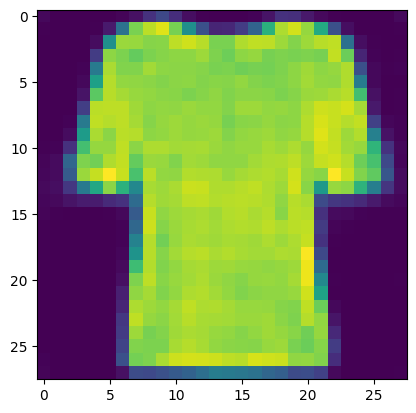

In [ ]:
e = e[0].unsqueeze(dim=0)
image = model.decode(e)
# print(image.get_device())
curr_image = image.detach().to(torch.device('cpu'))
plt.imshow(curr_image.view((28, 28)))

In [ ]:
# decode_image = model.decode(eee)

In [ ]:
X = np.linspace(-2.8509, 2.5332, 20)
Y = np.linspace(-2.8509, 2.5332, 20)
fig, axs = plt.subplots(20, 20, figsize = (150, 150))

# curr_image = decode_image.detach().to(torch.device('cpu'))
# e = eee.detach().to(torch.device('cpu'))
for idx, i in enumerate(X):
    e[:, 1] = i
    for idy, j in enumerate(Y):
        e[:, 5] = j
        image = model.decode(e)
        # print(image.get_device())
        curr_image = image.detach().to(torch.device('cpu'))
        axs[idx][idy].imshow(curr_image.view((28, 28)), cmap='binary')